# DQAN: DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.0481453  -0.1754543   0.01276553  0.27158581] 0 1.0 False {}
state, action, reward, done, info
[ 0.04463621  0.01948319  0.01819725 -0.01704363] 1 1.0 False {}
state, action, reward, done, info
[ 0.04502588  0.21433951  0.01785638 -0.30393002] 1 1.0 False {}
state, action, reward, done, info
[ 0.04931267  0.0189677   0.01177778 -0.00566952] 0 1.0 False {}
state, action, reward, done, info
[ 0.04969202  0.21391877  0.01166439 -0.29461327] 1 1.0 False {}
state, action, reward, done, info
[ 0.05397039  0.4088725   0.00577212 -0.58359472] 1 1.0 False {}
state, action, reward, done, info
[ 0.06214784  0.60391312 -0.00589977 -0.87445377] 1 1.0 False {}
state, action, reward, done, info
[ 0.07422611  0.79911478 -0.02338885 -1.16898569] 1 1.0 False {}
state, action, reward, done, info
[ 0.0902084   0.99453304 -0.04676856 -1.4689086 ] 1 1.0 False {}
state, action, reward, done, info
[ 0.11009906  1.19019503 -0.07614674 -1.77582562] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.19019503494412 -1.7758256239496488


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [6]:
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        return logits

In [7]:
def discriminator(actions, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [8]:
def model_loss(states, actions, action_size, hidden_size, state_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, 
                               state_size=state_size)
    actions_fake = tf.nn.softmax(actions_logits)
    d_logits_fake = discriminator(actions=actions_fake, hidden_size=hidden_size, action_size=action_size)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    d_logits_real = discriminator(actions=actions_real, hidden_size=hidden_size, action_size=action_size, 
                                  reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake

In [9]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [10]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, states=self.states, 
            hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [13]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [14]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [15]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            feed_dict={model.states: next_states}
            next_actions_logits, next_rewards_fake = sess.run([model.actions_logits, model.rewards_fake], feed_dict)

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = next_rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            # print('DEBUGGING', targetQs.shape, next_rewards_fake.shape, next_actions_logits.shape, np.max(next_actions_logits, axis=1).shape)

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.targetQs: targetQs}
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

Episode: 0 Total reward: 2.0 Training d_loss: 1.3819 Training g_loss: 0.6957 Training q_loss: 0.4228 Explore P: 0.9998
Episode: 1 Total reward: 22.0 Training d_loss: 1.2641 Training g_loss: 0.7505 Training q_loss: 0.9574 Explore P: 0.9976
Episode: 2 Total reward: 13.0 Training d_loss: 1.2183 Training g_loss: 0.7587 Training q_loss: 1.0621 Explore P: 0.9963
Episode: 3 Total reward: 21.0 Training d_loss: 1.3296 Training g_loss: 0.6998 Training q_loss: 7.0684 Explore P: 0.9943
Episode: 4 Total reward: 10.0 Training d_loss: 1.3580 Training g_loss: 0.7052 Training q_loss: 26.1713 Explore P: 0.9933
Episode: 5 Total reward: 22.0 Training d_loss: 1.3806 Training g_loss: 0.6885 Training q_loss: 48.8927 Explore P: 0.9911
Episode: 6 Total reward: 12.0 Training d_loss: 1.3623 Training g_loss: 0.7421 Training q_loss: 60.3909 Explore P: 0.9900
Episode: 7 Total reward: 43.0 Training d_loss: 1.4924 Training g_loss: 0.6991 Training q_loss: 110.9419 Explore P: 0.9857
Episode: 8 Total reward: 15.0 Traini

Episode: 68 Total reward: 20.0 Training d_loss: 1.3960 Training g_loss: 0.6877 Training q_loss: 1093.6335 Explore P: 0.8827
Episode: 69 Total reward: 10.0 Training d_loss: 1.3486 Training g_loss: 0.7685 Training q_loss: 80.8848 Explore P: 0.8818
Episode: 70 Total reward: 19.0 Training d_loss: 1.3068 Training g_loss: 0.7229 Training q_loss: 173.8569 Explore P: 0.8802
Episode: 71 Total reward: 16.0 Training d_loss: 1.3763 Training g_loss: 0.7067 Training q_loss: 109.5905 Explore P: 0.8788
Episode: 72 Total reward: 17.0 Training d_loss: 1.3118 Training g_loss: 0.7862 Training q_loss: 540.1492 Explore P: 0.8773
Episode: 73 Total reward: 38.0 Training d_loss: 1.3695 Training g_loss: 0.7171 Training q_loss: 894.0385 Explore P: 0.8740
Episode: 74 Total reward: 15.0 Training d_loss: 1.4567 Training g_loss: 0.6800 Training q_loss: 58.2454 Explore P: 0.8727
Episode: 75 Total reward: 16.0 Training d_loss: 1.3760 Training g_loss: 0.7418 Training q_loss: 588.3146 Explore P: 0.8714
Episode: 76 Total

Episode: 135 Total reward: 20.0 Training d_loss: 1.4192 Training g_loss: 0.6976 Training q_loss: 358.8964 Explore P: 0.7864
Episode: 136 Total reward: 8.0 Training d_loss: 1.3305 Training g_loss: 0.7119 Training q_loss: 77.9594 Explore P: 0.7857
Episode: 137 Total reward: 11.0 Training d_loss: 1.3781 Training g_loss: 0.7096 Training q_loss: 541.9468 Explore P: 0.7849
Episode: 138 Total reward: 39.0 Training d_loss: 1.2967 Training g_loss: 0.8347 Training q_loss: 779.1622 Explore P: 0.7819
Episode: 139 Total reward: 12.0 Training d_loss: 1.3382 Training g_loss: 0.7041 Training q_loss: 113.1132 Explore P: 0.7809
Episode: 140 Total reward: 20.0 Training d_loss: 1.3541 Training g_loss: 0.7154 Training q_loss: 1128.2581 Explore P: 0.7794
Episode: 141 Total reward: 14.0 Training d_loss: 1.3615 Training g_loss: 0.7001 Training q_loss: 239.8361 Explore P: 0.7783
Episode: 142 Total reward: 9.0 Training d_loss: 1.4439 Training g_loss: 0.8123 Training q_loss: 1290.2598 Explore P: 0.7776
Episode: 

Episode: 203 Total reward: 16.0 Training d_loss: 1.4820 Training g_loss: 0.7533 Training q_loss: 33.1858 Explore P: 0.7119
Episode: 204 Total reward: 15.0 Training d_loss: 1.3803 Training g_loss: 0.7269 Training q_loss: 209.0465 Explore P: 0.7109
Episode: 205 Total reward: 9.0 Training d_loss: 1.4092 Training g_loss: 0.7383 Training q_loss: 281.6677 Explore P: 0.7102
Episode: 206 Total reward: 9.0 Training d_loss: 1.3561 Training g_loss: 0.7052 Training q_loss: 101.5608 Explore P: 0.7096
Episode: 207 Total reward: 10.0 Training d_loss: 1.2850 Training g_loss: 0.8476 Training q_loss: 96.7925 Explore P: 0.7089
Episode: 208 Total reward: 10.0 Training d_loss: 1.3121 Training g_loss: 0.8069 Training q_loss: 440.5916 Explore P: 0.7082
Episode: 209 Total reward: 13.0 Training d_loss: 1.2365 Training g_loss: 0.8511 Training q_loss: 440.9206 Explore P: 0.7073
Episode: 210 Total reward: 15.0 Training d_loss: 1.2825 Training g_loss: 0.7747 Training q_loss: 209.2189 Explore P: 0.7062
Episode: 211

Episode: 271 Total reward: 16.0 Training d_loss: 1.2435 Training g_loss: 1.0035 Training q_loss: 181.1488 Explore P: 0.6465
Episode: 272 Total reward: 16.0 Training d_loss: 1.3121 Training g_loss: 0.8687 Training q_loss: 166.1380 Explore P: 0.6455
Episode: 273 Total reward: 11.0 Training d_loss: 1.3911 Training g_loss: 0.6228 Training q_loss: 58.3812 Explore P: 0.6448
Episode: 274 Total reward: 11.0 Training d_loss: 1.5362 Training g_loss: 0.6879 Training q_loss: 191.9726 Explore P: 0.6441
Episode: 275 Total reward: 17.0 Training d_loss: 1.4469 Training g_loss: 0.8179 Training q_loss: 159.9131 Explore P: 0.6430
Episode: 276 Total reward: 12.0 Training d_loss: 1.3863 Training g_loss: 0.6599 Training q_loss: 130.6233 Explore P: 0.6423
Episode: 277 Total reward: 12.0 Training d_loss: 1.2165 Training g_loss: 1.2096 Training q_loss: 152.4269 Explore P: 0.6415
Episode: 278 Total reward: 17.0 Training d_loss: 1.3659 Training g_loss: 0.7155 Training q_loss: 107.5090 Explore P: 0.6404
Episode: 

Episode: 338 Total reward: 9.0 Training d_loss: 1.2988 Training g_loss: 1.2374 Training q_loss: 455.7914 Explore P: 0.5982
Episode: 339 Total reward: 14.0 Training d_loss: 1.2270 Training g_loss: 1.0399 Training q_loss: 79.3867 Explore P: 0.5973
Episode: 340 Total reward: 12.0 Training d_loss: 1.3555 Training g_loss: 1.1083 Training q_loss: 46.4189 Explore P: 0.5966
Episode: 341 Total reward: 15.0 Training d_loss: 1.3081 Training g_loss: 0.8742 Training q_loss: 15.3995 Explore P: 0.5958
Episode: 342 Total reward: 15.0 Training d_loss: 1.2564 Training g_loss: 1.1160 Training q_loss: 112.4389 Explore P: 0.5949
Episode: 343 Total reward: 11.0 Training d_loss: 1.3795 Training g_loss: 0.6700 Training q_loss: 175.7767 Explore P: 0.5942
Episode: 344 Total reward: 12.0 Training d_loss: 1.1312 Training g_loss: 0.9709 Training q_loss: 233.3098 Explore P: 0.5935
Episode: 345 Total reward: 9.0 Training d_loss: 1.3822 Training g_loss: 0.5683 Training q_loss: 63.4890 Explore P: 0.5930
Episode: 346 T

Episode: 405 Total reward: 9.0 Training d_loss: 1.3439 Training g_loss: 1.0432 Training q_loss: 140.8910 Explore P: 0.5526
Episode: 406 Total reward: 15.0 Training d_loss: 1.2176 Training g_loss: 1.5071 Training q_loss: 354.7462 Explore P: 0.5518
Episode: 407 Total reward: 10.0 Training d_loss: 1.1511 Training g_loss: 1.4094 Training q_loss: 167.8754 Explore P: 0.5512
Episode: 408 Total reward: 11.0 Training d_loss: 1.3257 Training g_loss: 0.8497 Training q_loss: 286.6258 Explore P: 0.5506
Episode: 409 Total reward: 16.0 Training d_loss: 1.1792 Training g_loss: 0.8976 Training q_loss: 27.7650 Explore P: 0.5497
Episode: 410 Total reward: 14.0 Training d_loss: 1.3499 Training g_loss: 0.7134 Training q_loss: 82.3439 Explore P: 0.5490
Episode: 411 Total reward: 13.0 Training d_loss: 1.2174 Training g_loss: 0.8259 Training q_loss: 119.6065 Explore P: 0.5483
Episode: 412 Total reward: 10.0 Training d_loss: 1.3170 Training g_loss: 0.6893 Training q_loss: 131.6005 Explore P: 0.5478
Episode: 41

Episode: 472 Total reward: 9.0 Training d_loss: 1.2664 Training g_loss: 0.8524 Training q_loss: 25.0758 Explore P: 0.5124
Episode: 473 Total reward: 18.0 Training d_loss: 1.2262 Training g_loss: 0.7443 Training q_loss: 156.6674 Explore P: 0.5115
Episode: 474 Total reward: 16.0 Training d_loss: 1.2687 Training g_loss: 1.5755 Training q_loss: 71.9799 Explore P: 0.5106
Episode: 475 Total reward: 12.0 Training d_loss: 1.3545 Training g_loss: 0.6416 Training q_loss: 3.2119 Explore P: 0.5100
Episode: 476 Total reward: 10.0 Training d_loss: 1.3542 Training g_loss: 0.6770 Training q_loss: 47.5971 Explore P: 0.5095
Episode: 477 Total reward: 16.0 Training d_loss: 1.3803 Training g_loss: 0.7417 Training q_loss: 97.7644 Explore P: 0.5087
Episode: 478 Total reward: 13.0 Training d_loss: 1.3648 Training g_loss: 0.5439 Training q_loss: 97.5909 Explore P: 0.5081
Episode: 479 Total reward: 10.0 Training d_loss: 1.2904 Training g_loss: 0.9268 Training q_loss: 90.7793 Explore P: 0.5076
Episode: 480 Tota

Episode: 540 Total reward: 15.0 Training d_loss: 1.3032 Training g_loss: 2.4927 Training q_loss: 48.9874 Explore P: 0.4738
Episode: 541 Total reward: 8.0 Training d_loss: 1.2548 Training g_loss: 0.7988 Training q_loss: 69.3431 Explore P: 0.4735
Episode: 542 Total reward: 11.0 Training d_loss: 1.2119 Training g_loss: 0.9058 Training q_loss: 132.9385 Explore P: 0.4729
Episode: 543 Total reward: 12.0 Training d_loss: 1.3856 Training g_loss: 0.6275 Training q_loss: 738.5861 Explore P: 0.4724
Episode: 544 Total reward: 10.0 Training d_loss: 1.3412 Training g_loss: 0.7460 Training q_loss: 32.9452 Explore P: 0.4719
Episode: 545 Total reward: 9.0 Training d_loss: 1.1893 Training g_loss: 0.9488 Training q_loss: 59.9658 Explore P: 0.4715
Episode: 546 Total reward: 16.0 Training d_loss: 1.0844 Training g_loss: 2.7327 Training q_loss: 46.0879 Explore P: 0.4708
Episode: 547 Total reward: 22.0 Training d_loss: 1.3507 Training g_loss: 1.2233 Training q_loss: 65.8283 Explore P: 0.4698
Episode: 548 Tot

Episode: 607 Total reward: 17.0 Training d_loss: 1.3181 Training g_loss: 1.5293 Training q_loss: 285.5237 Explore P: 0.4303
Episode: 608 Total reward: 28.0 Training d_loss: 1.0627 Training g_loss: 1.3668 Training q_loss: 130.2311 Explore P: 0.4291
Episode: 609 Total reward: 10.0 Training d_loss: 1.2304 Training g_loss: 0.9434 Training q_loss: 155.9875 Explore P: 0.4287
Episode: 610 Total reward: 8.0 Training d_loss: 1.2751 Training g_loss: 0.7152 Training q_loss: 77.2094 Explore P: 0.4283
Episode: 611 Total reward: 12.0 Training d_loss: 1.2731 Training g_loss: 1.1514 Training q_loss: 92.7703 Explore P: 0.4278
Episode: 612 Total reward: 13.0 Training d_loss: 1.3168 Training g_loss: 1.2913 Training q_loss: 65.7426 Explore P: 0.4273
Episode: 613 Total reward: 9.0 Training d_loss: 1.4351 Training g_loss: 0.9191 Training q_loss: 78.1275 Explore P: 0.4269
Episode: 614 Total reward: 9.0 Training d_loss: 1.2020 Training g_loss: 2.5605 Training q_loss: 51.7224 Explore P: 0.4265
Episode: 615 Tot

Episode: 674 Total reward: 21.0 Training d_loss: 1.2369 Training g_loss: 1.0115 Training q_loss: 85.1526 Explore P: 0.3929
Episode: 675 Total reward: 10.0 Training d_loss: 1.3674 Training g_loss: 0.9819 Training q_loss: 104.9499 Explore P: 0.3925
Episode: 676 Total reward: 20.0 Training d_loss: 1.0601 Training g_loss: 1.1785 Training q_loss: 103.9346 Explore P: 0.3918
Episode: 677 Total reward: 9.0 Training d_loss: 1.2827 Training g_loss: 0.7596 Training q_loss: 25.1091 Explore P: 0.3914
Episode: 678 Total reward: 21.0 Training d_loss: 1.3096 Training g_loss: 0.6911 Training q_loss: 106.1210 Explore P: 0.3906
Episode: 679 Total reward: 17.0 Training d_loss: 1.0501 Training g_loss: 1.1480 Training q_loss: 262.6338 Explore P: 0.3900
Episode: 680 Total reward: 15.0 Training d_loss: 1.1623 Training g_loss: 1.0129 Training q_loss: 50.1259 Explore P: 0.3894
Episode: 681 Total reward: 17.0 Training d_loss: 1.2182 Training g_loss: 0.8916 Training q_loss: 52.5969 Explore P: 0.3888
Episode: 682 

Episode: 741 Total reward: 24.0 Training d_loss: 1.3154 Training g_loss: 1.7051 Training q_loss: 1693.6257 Explore P: 0.3328
Episode: 742 Total reward: 30.0 Training d_loss: 1.4155 Training g_loss: 0.6362 Training q_loss: 2009.1758 Explore P: 0.3319
Episode: 743 Total reward: 34.0 Training d_loss: 1.2303 Training g_loss: 1.0957 Training q_loss: 189.5311 Explore P: 0.3308
Episode: 744 Total reward: 44.0 Training d_loss: 1.3888 Training g_loss: 0.6994 Training q_loss: 1085.6357 Explore P: 0.3294
Episode: 745 Total reward: 32.0 Training d_loss: 1.3494 Training g_loss: 0.8018 Training q_loss: 72.5895 Explore P: 0.3283
Episode: 746 Total reward: 31.0 Training d_loss: 1.4644 Training g_loss: 0.5985 Training q_loss: 3102.0044 Explore P: 0.3273
Episode: 747 Total reward: 49.0 Training d_loss: 1.3370 Training g_loss: 0.9535 Training q_loss: 339.1548 Explore P: 0.3258
Episode: 748 Total reward: 39.0 Training d_loss: 1.3893 Training g_loss: 0.7415 Training q_loss: 177.5330 Explore P: 0.3246
Episo

Episode: 807 Total reward: 102.0 Training d_loss: 1.1355 Training g_loss: 1.9830 Training q_loss: 58.6069 Explore P: 0.2247
Episode: 808 Total reward: 78.0 Training d_loss: 1.3192 Training g_loss: 0.7121 Training q_loss: 338.2249 Explore P: 0.2230
Episode: 809 Total reward: 86.0 Training d_loss: 1.3772 Training g_loss: 0.6797 Training q_loss: 43.2748 Explore P: 0.2212
Episode: 810 Total reward: 70.0 Training d_loss: 1.3196 Training g_loss: 1.4482 Training q_loss: 328.8898 Explore P: 0.2197
Episode: 811 Total reward: 84.0 Training d_loss: 1.3815 Training g_loss: 0.7499 Training q_loss: 49.5151 Explore P: 0.2180
Episode: 812 Total reward: 66.0 Training d_loss: 1.3012 Training g_loss: 0.9036 Training q_loss: 249.1329 Explore P: 0.2166
Episode: 813 Total reward: 116.0 Training d_loss: 1.1550 Training g_loss: 1.4541 Training q_loss: 211.4352 Explore P: 0.2142
Episode: 814 Total reward: 42.0 Training d_loss: 1.3074 Training g_loss: 0.7256 Training q_loss: 61.3589 Explore P: 0.2134
Episode: 8

Episode: 874 Total reward: 199.0 Training d_loss: 1.3226 Training g_loss: 1.4622 Training q_loss: 36.8688 Explore P: 0.1413
Episode: 875 Total reward: 167.0 Training d_loss: 1.3262 Training g_loss: 0.7496 Training q_loss: 28.5051 Explore P: 0.1391
Episode: 876 Total reward: 120.0 Training d_loss: 1.2952 Training g_loss: 1.5523 Training q_loss: 12.4181 Explore P: 0.1376
Episode: 877 Total reward: 192.0 Training d_loss: 1.2491 Training g_loss: 1.5377 Training q_loss: 61.9436 Explore P: 0.1351
Episode: 878 Total reward: 191.0 Training d_loss: 1.2781 Training g_loss: 1.7227 Training q_loss: 2265.2930 Explore P: 0.1328
Episode: 879 Total reward: 159.0 Training d_loss: 1.2841 Training g_loss: 1.0704 Training q_loss: 32.8361 Explore P: 0.1308
Episode: 880 Total reward: 177.0 Training d_loss: 1.3608 Training g_loss: 0.9530 Training q_loss: 80.6949 Explore P: 0.1287
Episode: 881 Total reward: 199.0 Training d_loss: 1.4373 Training g_loss: 2.3591 Training q_loss: 148.5244 Explore P: 0.1264
Episo

Episode: 940 Total reward: 191.0 Training d_loss: 1.4017 Training g_loss: 1.5069 Training q_loss: 66.8081 Explore P: 0.0555
Episode: 941 Total reward: 199.0 Training d_loss: 1.0442 Training g_loss: 3.9500 Training q_loss: 38.9811 Explore P: 0.0546
Episode: 942 Total reward: 199.0 Training d_loss: 1.3409 Training g_loss: 0.6394 Training q_loss: 139.7287 Explore P: 0.0537
Episode: 943 Total reward: 158.0 Training d_loss: 1.1805 Training g_loss: 1.5388 Training q_loss: 143.2993 Explore P: 0.0530
Episode: 944 Total reward: 120.0 Training d_loss: 1.1553 Training g_loss: 1.8233 Training q_loss: 129.3923 Explore P: 0.0525
Episode: 945 Total reward: 162.0 Training d_loss: 1.0702 Training g_loss: 1.8792 Training q_loss: 141.7618 Explore P: 0.0518
Episode: 946 Total reward: 140.0 Training d_loss: 1.1151 Training g_loss: 2.4717 Training q_loss: 85.7932 Explore P: 0.0512
Episode: 947 Total reward: 114.0 Training d_loss: 1.1877 Training g_loss: 1.3911 Training q_loss: 90.7271 Explore P: 0.0508
Epis

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

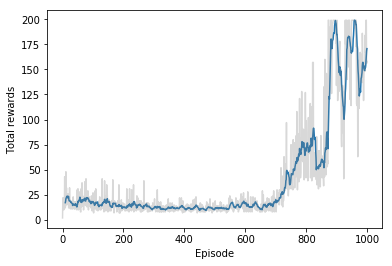

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

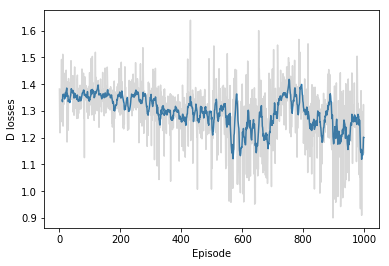

In [19]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

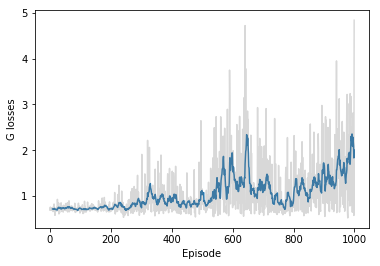

In [22]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

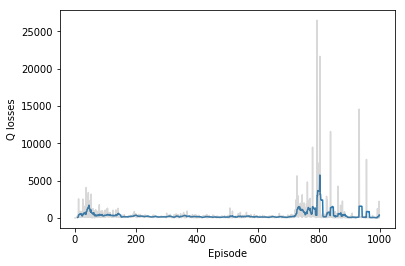

In [23]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [26]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.